# Waste-Sorter CNN Using TensorFlow 2.0

Based on the work by Collin Ching, who built a Waste classifier based on fastai / PyTorch, I'm going to replicate the same model using keras (TensorFlow). There are two main resources I've followed as a guide to import the data and build the model:

- [Load Images](https://www.tensorflow.org/tutorials/load_data/images)
- [CNN](https://www.tensorflow.org/tutorials/images/cnn)
- [Transfer learning with a pretrained ConvNet](https://www.tensorflow.org/tutorials/images/transfer_learning)

## Imports

In [0]:
import pathlib
import numpy as np
import IPython.display as display
from PIL import Image
import os

### Import TensorFlow

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Import and organize the data

As in the previous notebook, the first step is to import the images [datataset](https://github.com/garythung/trashnet/#dataset). The dataset contains 2527 images organized by material in different folders:

- 501 glass
- 594 paper
- 403 cardboard
- 482 plastic
- 410 metal
- 137 trash

In the previous notebook, Collin used some helper functions and the resquests and zipfile libraries to import the images and build the folder structure. In this case, we're going to use the keras.utils.get_file function to obtain the images:

In [0]:
data_dir = tf.keras.utils.get_file(origin='https://github.com/bartomolina/dscapstone/blob/master/data/dataset-resized.zip?raw=true', fname='dataset-resized', extract=True, archive_format='zip')
data_dir = pathlib.Path(data_dir)

In [41]:
# verify the data directory
print(data_dir)

# number of images imported
image_count = len(list(data_dir.glob('*/*.jpg')))
print (f'{image_count} images imported')

/root/.keras/datasets/dataset-resized
2527 images imported


AS before, let's have a look at the different classes (given by each of the subfolders within our data directory) and check some of the images:

In [57]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"])
CLASS_NAMES

array(['paper', 'trash', 'plastic', 'metal', 'cardboard', 'glass'],
      dtype='<U9')

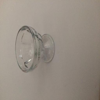

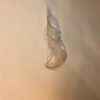

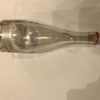

In [248]:
glass = list(data_dir.glob('glass/*'))

for image_path in glass[:3]:
    im = Image.open(str(image_path))
    display.display(im.resize((100, 100)))

### Loading images with TensorFlow `tf.data`

In the previous notebook, Collin used the fastai library to load the Images following an ImageNet structure. While working with TensorFlow / keras you have mainly two options to achieve this:

- Use the `tf.keras.preprocessing` method
- Load the images directly into a `tf.data.Dataset`

We're going to use the second method as it has presents some advantages over keras:

- Better performance
- Allows for a more fine-grained control
- Beeter integration with the rest of TensorFlow

In [0]:
# import our files into a dataset
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [61]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/dataset-resized/paper/paper264.jpg'
b'/root/.keras/datasets/dataset-resized/paper/paper564.jpg'
b'/root/.keras/datasets/dataset-resized/paper/paper262.jpg'
b'/root/.keras/datasets/dataset-resized/metal/metal342.jpg'
b'/root/.keras/datasets/dataset-resized/paper/paper227.jpg'


Helper functions to process the images

In [0]:
# gets the class for a given file path
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
# decode image file
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

In [0]:
# gets the image and label for a given file
def process_path(file_path):
  print(get_label(file_path).numpy())
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Using the helper functions above, we can generate a dataset with all the image, label pairs:

In [264]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

AttributeError: ignored

Same as before, we're going to split our dataset into train / test / validation (50-25-25):

In [0]:
DATASET_SIZE = tf.data.experimental.cardinality(labeled_ds).numpy()
BUFFER_SIZE = DATASET_SIZE

train_size = int(0.5 * DATASET_SIZE)
val_size = int(0.25 * DATASET_SIZE)
test_size = int(0.25 * DATASET_SIZE)


full_dataset = labeled_ds.shuffle(BUFFER_SIZE)
train_dataset = labeled_ds.take(train_size)
test_dataset = labeled_ds.skip(train_size)
val_dataset = test_dataset.take(val_size)
test_dataset = test_dataset.skip(val_size)

We're going to define another helper function to show some of the images:

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

Let's look at the images in the different datasets:

**TRAIN**

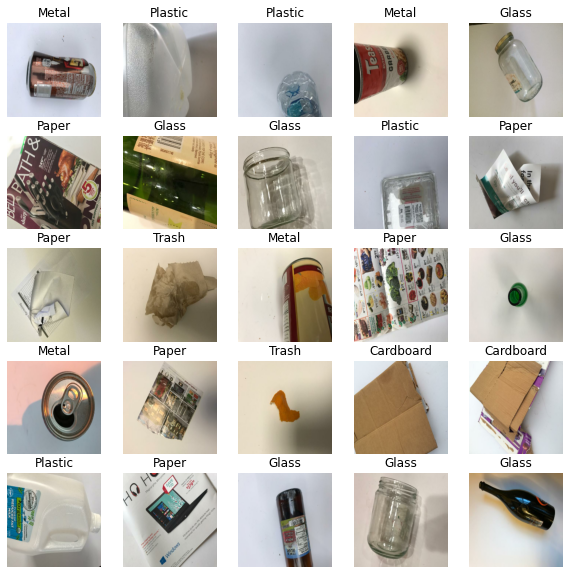

In [257]:
image_batch, label_batch = next(iter(train_dataset.batch(25)))
show_batch(image_batch.numpy(), label_batch.numpy())

**TEST**

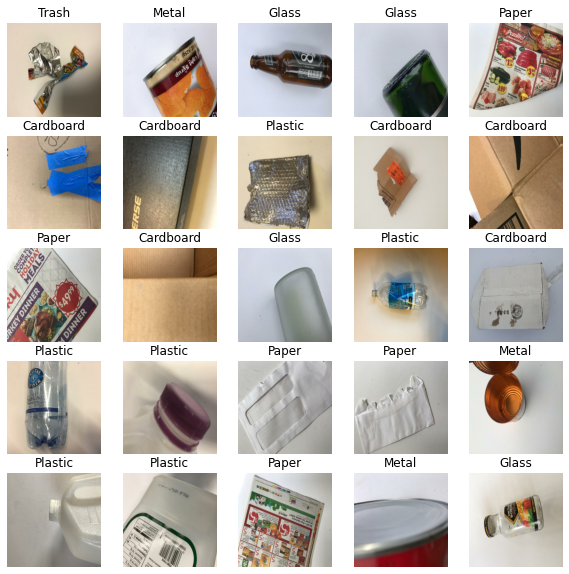

In [238]:
image_batch, label_batch = next(iter(test_dataset.batch(25)))
show_batch(image_batch.numpy(), label_batch.numpy())

**VALIDATE**

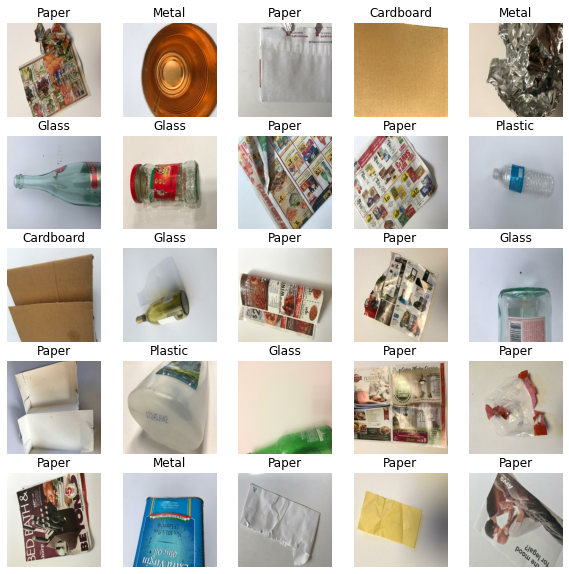

In [240]:
image_batch, label_batch = next(iter(val_dataset.batch(25)))
show_batch(image_batch.numpy(), label_batch.numpy())

Now that we've prepared our dataset, we're going to proceed to build our Model.

## Model

In [242]:
IMG_SHAPE = (512, 384, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SHAPE), include_top=False, weights='imagenet')

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step


In [250]:


for image_batch, label_batch in train_dataset.batch(32).take(1):
   pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [252]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)
